# PXD022545
## Proteomic analysis of ARPE-19 cells exposed to chronic H2O2 treatment
[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD022545)

[Article link](https://www.mdpi.com/2076-3921/10/1/25)

In [4]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

# Analysis without quant data

In [29]:
first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD022545_first.csv", index_col=0)
del first["Unnamed: 0"]
del first["Unnamed: 0.1"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

/tmp/ipykernel_1356242/4217098548.py:1: DtypeWarning: Columns (25,29) have mixed types. Specify dtype option on import or set low_memory=False.
  first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD022545_first.csv", index_col=0)


In [30]:
first.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0_8_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,790.34769,7903.4568,0.88133,2,EAADTER,EAADTER,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
1,0_7572_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,1911.78352,19117.8054,1163.81700,4,SEEAHAEDSVMDHHFR,SEEAHAEDSVMDHHFR,11|[35]oxidation[M],11|15.9949,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
2,0_7573_4,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,762.36667,7623.6603,1163.86404,2,GTFPDAR,GTFPDAR,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
3,0_7574_2,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,939.45005,9394.4836,1163.91264,2,VMEYINR,VMEYINR,2|[35]oxidation[M],2|15.9949,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First
4,0_7575_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,895.40507,8954.0354,1164.25452,2,ESFDGSVR,ESFDGSVR,None,0|,...,Human,ARPE-19,None,0,None,0.0,0,0.0,NaN,First


In [31]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  110369
The amount of raw files that make up the master dataset is:  6


In [32]:
os.chdir("/home/robbe/ionbot")

In [33]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [34]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,H2O2,10,Chronic,None,0.0,0.0,26770
1,None,0,0,None,0.0,0.0,72283


## Comparison between the treatments


In [35]:
H2O2 = first.loc[lambda first: first["Oxidant treatment"] == "H2O2"]
Control = first.loc[lambda first: first["Oxidant treatment"] == "None"]
print("There are this many replicates of each treatment: {}".format(H2O2["spectrum_file"].nunique()))
print("The H2O2 treatment contains this many PSMs: {}".format(H2O2.shape[0]))
print("The Control treatment contains this many PSMs: {}".format(Control.shape[0]))

There are this many replicates of each treatment: 3
The H2O2 treatment contains this many PSMs: 38086
The Control treatment contains this many PSMs: 72283


In [36]:
H2O2rep = OA.replicate_filter(H2O2, 2)
Controlrep = OA.replicate_filter(Control, 2)

### Oxidatively modified PSMs

In [37]:
print("The ratio of PSMs that contain an oxidative modification in the H2O2 treatment subset: {}".format((H2O2rep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the H2O2 treatment subset: 19.36704621567314 %
The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 20.46986756100065 %


There is barely any difference between the ratio of oxidized PSMs between the treatment and control set-ups.

In [38]:
mrH2O2rep = OA.modratios(H2O2rep)
mrControlrep = OA.modratios(Controlrep)

In [39]:
modr = pd.merge(mrH2O2rep,mrControlrep, on="Modification", suffixes=('_H2O2', '_Control'))
modr["Difference"] = modr["Ratios_H2O2"] - modr["Ratios_Control"]
modr = modr.drop(modr[(modr["Ratios_H2O2"] == 0) & (modr["Ratios_Control"] == 0)].index)
modr


,Modification,Ratios_H2O2,Ratios_Control,Difference
0,[35]Oxidation[T],0.000736,0.000669,6.720035e-05
1,[35]Oxidation[E],0.000984,0.000861,1.233295e-04
2,[35]Oxidation[S],0.000712,0.000564,1.476357e-04
3,[35]Oxidation[Q],0.000364,0.000901,-5.368521e-04
5,[35]Oxidation[I],0.000455,0.000536,-8.100983e-05
7,[35]Oxidation[G],0.000811,0.000721,9.000527e-05
8,[35]Oxidation[W],0.008796,0.008491,3.053090e-04
10,[35]Oxidation[H],0.000447,0.000314,1.326267e-04
11,[35]Oxidation[V],0.000583,0.000327,2.558718e-04
12,[35]Oxidation[R],0.000720,0.000628,9.140154e-05


/home/robbe/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


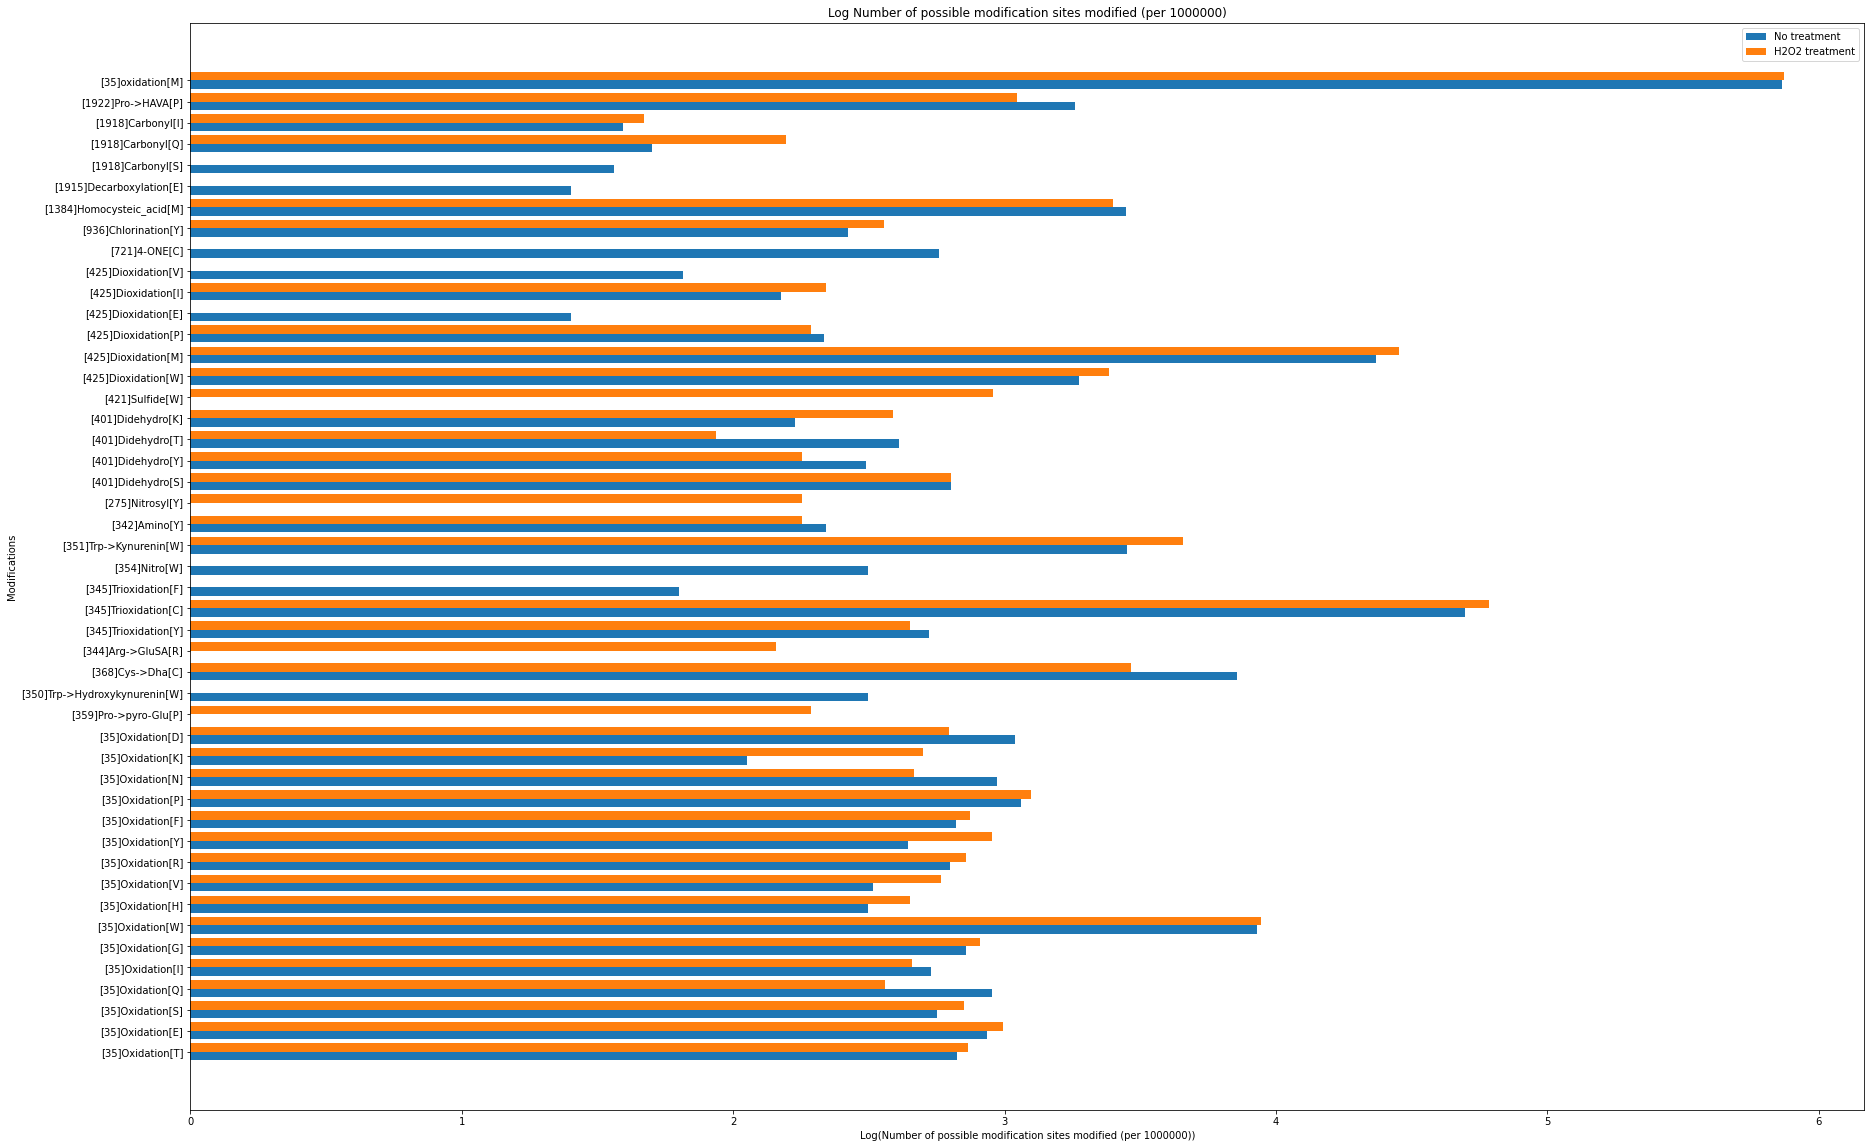

In [40]:
y = modr["Modification"]
xnone = np.log10(modr['Ratios_Control']*1000000)
xH = np.log10(modr['Ratios_H2O2']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of possible modification sites modified (per 1000000))")
plt.title("Log Number of possible modification sites modified (per 1000000)")

plt.legend()
plt.show()

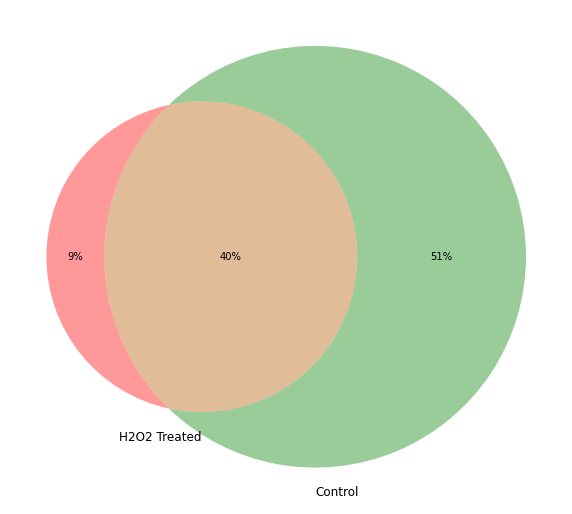

In [41]:
OA.condition_venn([H2O2rep, Controlrep], ["H2O2 Treated", "Control"])

In [42]:
difflist, pf_only_treatment = OA.comparelist(H2O2rep,Controlrep)
pf_only_treatment

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
72284,0_7331_3,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.44523,7574.4460,1250.76810,2,AGIIASAR,AGIIASAR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,AGIIASAR,None,None,False
72299,0_7402_4,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,946.45188,9464.5083,1258.52490,2,VTEQEWR,VTEQEWR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,VTEQEWR,None,None,False
72307,0_7453_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,1130.59411,11296.0910,1264.48866,3,VRVEISNGEK,VRVEISNGEK,7|[7]Deamidated[N],7|0.9840,...,None,NaN,Chronic,0.0,NaN,First,VRVEISN[7]DeamidatedGEK,7,[7]Deamidated[N],False
72316,0_7493_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,1045.50596,10455.0396,1269.82716,2,SIAAEEEAAR,SIAAEEEAAR,None,0|,...,None,NaN,Chronic,0.0,NaN,First,SIAAEEEAAR,None,None,False
72320,0_7509_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,922.40751,8904.1673,1272.02028,2,IMEDIDR,IMEDIDR,2|[425]Dioxidation[M],2|31.9898,...,None,NaN,Chronic,0.0,NaN,First,IM[425]DioxidationEDIDR,2,[425]Dioxidation[M],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110347,0_7323_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,838.37180,7323.2897,1203.97002,2,EDGDGIK,EDYDGIK,3|Gly->Tyr[G],0|,...,None,0.0,Chronic,0.0,NaN,First,EDYGly->TyrDGIK,3,Gly->Tyr[G],False
110348,0_7326_2,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,984.50437,9845.0287,1204.41288,2,SPFEQHIK,SPFEQHIK,None,0|,...,None,0.0,Chronic,0.0,NaN,First,SPFEQHIK,None,None,False
110360,0_7367_1,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.35081,7574.4460,1211.11392,2,AGIIASAR,AGIIASAR,None,0|,...,None,0.0,Chronic,0.0,NaN,First,AGIIASAR,None,None,False
110362,0_7379_3,2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O...,757.44541,7574.4460,1213.03350,2,AGIIASAR,AGIIASAR,None,0|,...,None,0.0,Chronic,0.0,NaN,First,AGIIASAR,None,None,False


In [43]:
onlytreatment = OA.modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)

In [44]:
onlytreatment

,Modification,Counts
129,[35]oxidation[M],655
80,[425]Dioxidation[M],40
33,[345]Trioxidation[C],36
7,[35]Oxidation[G],15
121,[1922]Pro->HAVA[P],14
1,[35]Oxidation[E],14
5,[35]Oxidation[I],12
2,[35]Oxidation[S],10
16,[35]Oxidation[P],10
11,[35]Oxidation[V],9


In [45]:
RPMH2O2 = OA.relative_PSM_modification(H2O2rep)
RPMControl = OA.relative_PSM_modification(Controlrep)

In [46]:
RPM = pd.merge(RPMH2O2,RPMControl, on="Amino acid", suffixes=('_H2O2', '_Control'))
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_H2O2,Relative level of PSMs containing unmodified residue_Control
0,A,0.998501,0.998404
1,R,0.997341,0.998255
2,N,0.957743,0.960266
3,D,0.991302,0.986433
4,C,0.348612,0.335125
5,Q,0.987363,0.985622
6,E,0.988871,0.986962
7,G,0.998493,0.998037
8,H,0.994679,0.996537
9,I,0.998163,0.998255


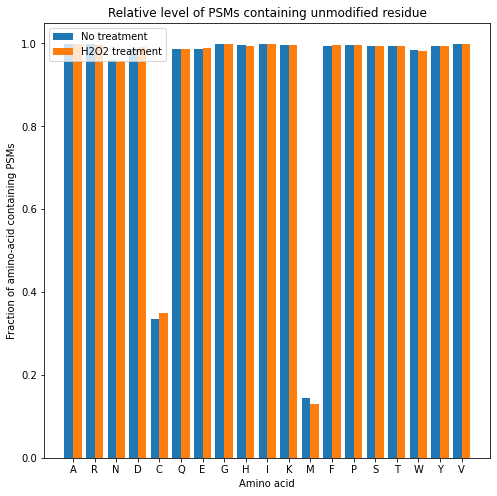

In [47]:
x = RPM["Amino acid"]
xnone = RPM["Relative level of PSMs containing unmodified residue_Control"]
xH = RPM['Relative level of PSMs containing unmodified residue_H2O2']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

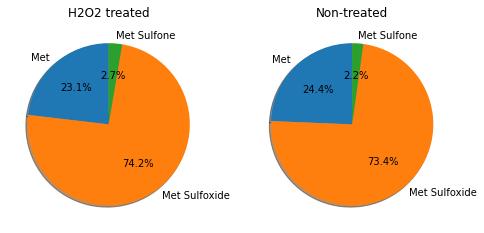

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(H2O2rep, ax1)
OA.methionine_overview(Controlrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

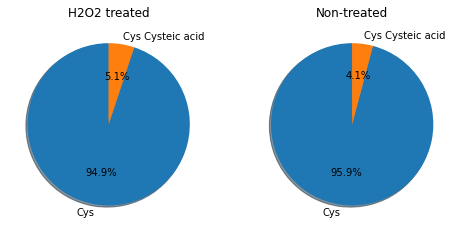

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(H2O2rep, ax1)
OA.cysteine_overview(Controlrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

In [ ]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [27]:
diffox, statement = OA.differentially_oxidized_psms(H2O2rep,Controlrep)
with open("diffoxPXD022545.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

# Analysis with quant data

In [6]:
quant = pd.read_csv("/home/robbe/ionbot/PXD022545/raw_files/QuantifiedPeptides.tsv", "\t") 
quant.drop(list(quant.filter(regex = 'Detection Type')), axis = 1, inplace = True)

In [13]:
Nonmodified = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("M")]
Sulfoxide = quant.loc[quant["Sequence"].str.contains("[35]oxidation[M]",regex=False)]
Sulfone = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[M]", regex = False)]
Nonmodifiednums = Nonmodified.append(Nonmodified.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfoxidenums = Sulfoxide.append(Sulfoxide.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfonenums = Sulfone.append(Sulfone.sum(numeric_only=True), ignore_index=True)[-1:]
moddf = [Nonmodifiednums, Sulfoxidenums, Sulfonenums]

In [42]:
Controldict = {}
Treatmentdict = {}
sizesC = []
sizesT = []
for i in moddf:
    name = 0
    df = i.filter(regex=r'(H2O2|CTRL)')
    dfmeds = df.groupby(df.columns.str.extract(pat=r'(H2O2|CTRL)', expand=False),axis=1).median().add_prefix('med_')
    
    Controlsub = dfmeds.loc[:, dfmeds.columns.str.contains("CTRL")]
    Treatmentsub = dfmeds.loc[:, dfmeds.columns.str.contains("H2O2")]
    Treatmentsum = Treatmentsub.sum(axis=1).values[0]
    Controlsum = Controlsub.sum(axis=1).values[0]
    # Treatmentdict[str(name)] = Treatmentsum.values[0]
    # Controldict[str(name)] = Controlsum.values[0]
    sizesC.append(Controlsum)
    sizesT.append(Treatmentsum)

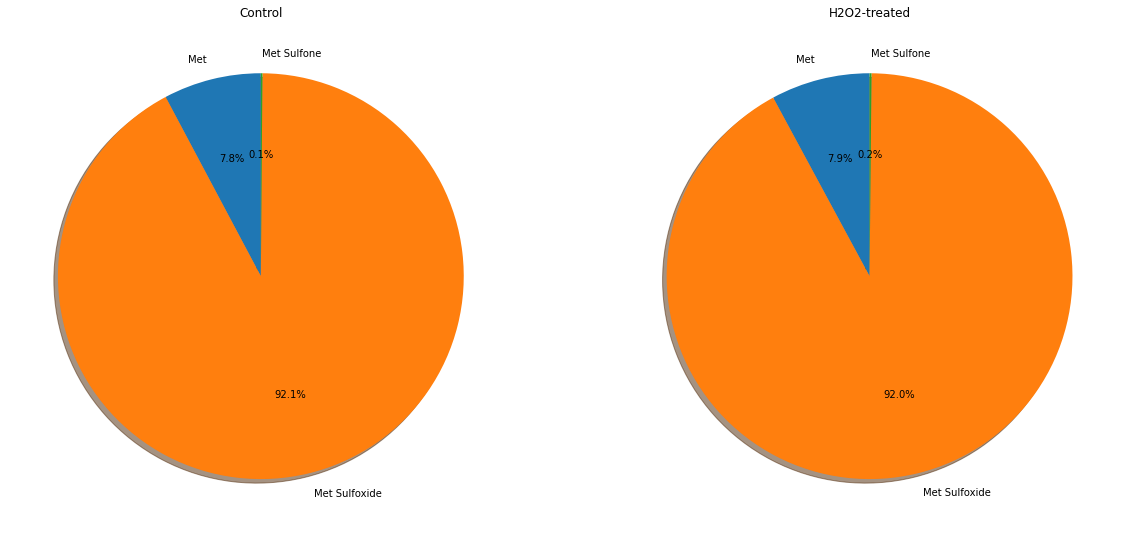

In [44]:
labels = ["Met", "Met Sulfoxide", "Met Sulfone"]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesC, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizesT, labels=labels, autopct='%1.1f%%', shadow= True, startangle= 90)
plt.title("Methionine containing peptides")
ax1.set_title("Control")
ax2.set_title("H2O2-treated")
fig.set_size_inches(20,40)
plt.show()

In [45]:
NonmodifiedC = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("C")]
Sulfenic = quant.loc[quant["Sequence"].str.contains("[35]oxidation[C]",regex=False)]
Sulfinic = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[C]", regex = False)]
Cysteic = quant.loc[quant["Sequence"].str.contains("[345]Trioxidation[C]", regex = False)]
Non_modified = NonmodifiedC.append(NonmodifiedC.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfenic_acid = Sulfenic.append(Sulfenic.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfinic_acid = Sulfinic.append(Sulfinic.sum(numeric_only=True), ignore_index=True)[-1:]
Cysteic_acid = Cysteic.append(Cysteic.sum(numeric_only=True), ignore_index=True)[-1:]
moddfc = [Non_modified, Sulfenic_acid, Sulfinic_acid, Cysteic_acid]

In [46]:
Controldict = {}
Treatmentdict = {}
for i in moddfc:
    name = OA.retrieve_name(i)[1]
    df = i.filter(regex=r'(H2O2|CTRL)')
    Controlsub = df.loc[:, df.columns.str.contains("CTRL")]
    Treatmentsub = df.loc[:, df.columns.str.contains("H2O2")]
    Controlsum = Controlsub.sum(axis=1)
    Treatmentsum = Treatmentsub.sum(axis=1)
    Controldict[name] = Controlsum.values[0]
    Treatmentdict[name] = Treatmentsum.values[0]


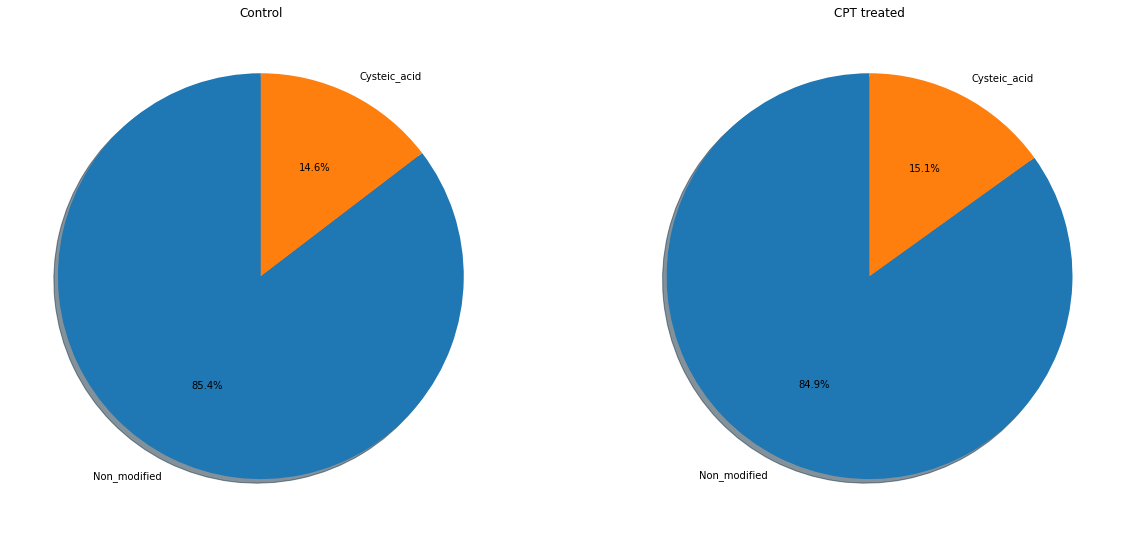

In [47]:
labelsC = []
labelsT = []

sizesC = []
sizesT = []


for x, y in Controldict.items():
    if y != 0:
        labelsC.append(x)
        sizesC.append(y)
for x, y in Treatmentdict.items():
    if y != 0:
        labelsT.append(x)
        sizesT.append(y)


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesC, labels=labelsC, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizesT, labels=labelsT, autopct='%1.1f%%', shadow= True, startangle= 90)
ax1.set_title("Control")
ax2.set_title("CPT treated")
fig.set_size_inches(20,40)
plt.show()